In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 吉林資料整合

In [2]:
patent_df = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-吉林.xls')

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'22\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [5]:
patent_df_firm.shape

(1601, 38)

In [6]:
firm_gd.shape

(5062, 6)

In [7]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

In [8]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\吉林_廠商.xlsx')

# merge舊資料

In [4]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(252, 44)
(5561, 44)
(1713, 49)
(5561, 49)


In [5]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\吉林_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str',
       'name_模糊比對', '序号', '标题', '文献页数', '合享价值度', '链接到incoPat', '公开（公告）号',
       '公开（公告）日', '申请号', '申请日', '申请人', '标准化申请人', '申请人国别代码', '申请人省市代码',
       '中国申请人地市', '中国申请人区县', '申请人地址', '申请人类型', '优先权信息', '权利要求数量', '专利类型',
       '发明人', 'IPC', 'CPC', '简单同族', '扩展同族', 'inpadoc同族', '同族国家', '简单同族个数',
       '扩展同族个数', 'inpadoc同族个数', '引证专利', '被引证专利', '被引证次数', '引证科技文献', '专利寿命（月）',
       '被引证国别(forward)', '失效日', '公开国别', 'name', 'address', '完整地址', 'lat',
       'lnt', '長春', '吉林', '延吉', '長春淨月', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [6]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','長春','吉林','延吉','長春淨月','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(1024, 56)

In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\吉林_結果.xlsx')

# 非模糊比對

In [9]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(476, 45)
(6187, 45)


In [10]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(2159, 50)
(5346, 50)


D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A

In [11]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\吉林_結果.xlsx')

# 模糊比對

In [12]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

(537, 45)
(6101, 45)


In [13]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

(2119, 50)
(5270, 50)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\吉林_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\吉林_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\吉林_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(1024, 56)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [5]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(5561, 56)
(37, 56)


In [6]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\吉林_結果.xlsx')

# 作圖

In [7]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [8]:
patent_count.sort_values()

申请人2
VTT NTM有限责任公司             1
温丹岩                       1
温京潮                       1
温兵野                       1
温凤友                       1
                       ... 
中国第一汽车股份有限公司           1123
中国第一汽车集团公司             1198
中国科学院长春光学精密机械与物理研究所    1896
中国科学院长春应用化学研究所         1954
吉林大学                   5524
Name: 專利數, Length: 21132, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\吉林_結果.xlsx',index_col=0)
target1 = (43.82166,125.25319)
merge_df['長春'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (43.81899,126.5512)
merge_df['吉林'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (42.89584,129.53427)
merge_df['延吉'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (43.78275,125.42325)
merge_df['長春淨月'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [9]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\吉林_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (43.82166,125.25319)
target2 = (43.81899,126.5512)
target3 = (42.89584,129.53427)
target4 = (43.78275,125.42325)

for i in merge_df[merge_df['長春']==''].index:
    merge_df.loc[i,'長春'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'吉林'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'延吉'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'長春淨月'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [10]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['長春']<10)or(x['吉林']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['延吉']<10)or(x['長春淨月']<10)) else 0,axis=1)

In [11]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\吉林_結果.xlsx')

In [12]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(5561, 56)
0.8002157885272433
0.0008991188635137566


In [13]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       4450
1.0        362
2.0        182
3.0        105
4.0         70
5.0         47
6.0         50
7.0         32
8.0         34
9.0         23
10.0        22
11.0        15
12.0        11
13.0        16
14.0         6
15.0        15
16.0        12
17.0         8
18.0         3
19.0         7
20.0        10
21.0         9
22.0         1
23.0         7
24.0         4
25.0         4
26.0         2
27.0         2
28.0         3
29.0         2
30.0         4
31.0         1
32.0         2
33.0         1
34.0         2
35.0         1
36.0         2
37.0         3
38.0         1
39.0         3
40.0         2
41.0         3
42.0         2
44.0         1
46.0         1
48.0         1
52.0         1
53.0         1
54.0         1
55.0         1
56.0         1
57.0         1
70.0         1
71.0         1
74.0         1
79.0         1
80.0         1
85.0         1
123.0        1
129.0        1
776.0        1
1123.0       1
1198.0       1
Name: IPC, dtype: int64

In [14]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0    35
1.0     1
4.0     1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

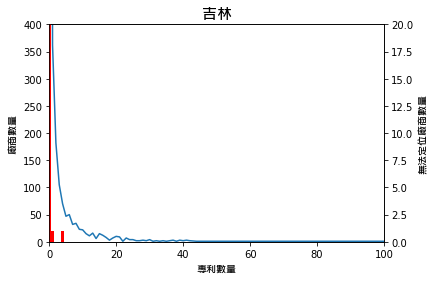

In [15]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('吉林',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,400])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,20])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\吉林_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','责任','集团','股份','控股','总公司','分公司','公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

476
0.08660844250363901
0


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1     187
2     102
3      36
4      28
5      23
6      11
7       7
8      12
9       9
10     11
11      4
12      4
13      4
14      1
15      5
16      5
17      4
18      1
20      2
21      3
23      2
25      2
28      1
29      1
30      1
33      1
34      1
35      1
37      1
39      1
42      1
54      1
57      1
71      1
74      1
Name: IPC, dtype: int64

In [4]:
not_merge[not_merge['專利數']>=50].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,序号,标题,文献页数,合享价值度,链接到incoPat,公开（公告）号,公开（公告）日,申请号,申请日,标准化申请人,申请人国别代码,申请人省市代码,中国申请人地市,中国申请人区县,申请人地址,申请人类型,优先权信息,权利要求数量,专利类型,...,简单同族个数,扩展同族个数,inpadoc同族个数,引证专利,被引证专利,被引证次数,引证科技文献,专利寿命（月）,被引证国别(forward),失效日,公开国别,申请人,name,address,完整地址,lat,lnt,長春,吉林,延吉,長春淨月,早期園區,近期園區,專利數,name_clean
5486,,,,,,,3922,含硅的苯并蒽类有机发光材料及其制备方法和应用,11,8,到incoPat中查看\r\nCN103834381B,CN103834381B,2015-10-28 00:00:00,CN201210476615.2,2012-11-21 00:00:00,,中国,吉林; 22,[长春],[朝阳],吉林省长春市高新区繁荣路5299号,企业,,9,发明授权,...,2,2,2,GB0031634D0; US20080100208A1; WO2011115378A1,,0,,,,,CN,吉林奥来德光电材料股份有限公司,吉林奥来德光电材料股份有限公司,吉林省长春市高新区繁荣路5299号,1,43.8337,125.263,1.537500,103.664405,361.534592,14.109592,1,0,54,吉林奥来德光电材料
5465,,,,,,,276,基于相位搜索的电缆线路避雷器阻性电流检测方法,11,9,到incoPat中查看\r\nCN102901856B,CN102901856B,2017-11-28 00:00:00,CN201210343630.X,2012-09-17 00:00:00,[国家电网-C; 东北电大-E],中国,吉林; 22,[长春],[朝阳],吉林省长春市朝阳区人民大街4969号,企业,,4,发明授权,...,2,2,2,CN1797014A; CN2099319U; CN101359016A; CN101986164A; CN101762767A; JP2004120833A,,0,"<text>杨利萍.金属氧化物避雷器漏电流检测的相位补偿法.《高压电器》.2000, (第6期), </text>",,,,CN,吉林省电力有限公司长春供电公司,吉林省电力有限公司长春供电公司,吉林省长春市朝阳区人民大街4969号,1,43.8643,125.325,7.452994,98.763057,357.649103,12.043860,1,0,57,吉林省电力长春供电
5502,,,,,,,4387,具有载波通讯接口的电压互感器,7,8,到incoPat中查看\r\nCN103035392B,CN103035392B,2015-08-12 00:00:00,CN201210575582.7,2012-12-27 00:00:00,[国家电网-C],中国,吉林; 22,[长春],[朝阳],吉林省长春市朝阳区人民大街4433号,企业,,4,发明授权,...,2,2,2,US4016429A; US20080077336A1; CN101373906A; CN201594823U; US20100318238A1; CN201830516U; CN202977156U,,0,,,,,CN,吉林省电力有限公司电力科学研究院,吉林省电力有限公司电力科学研究院,吉林省长春市朝阳区人民大街4433号,1,43.8694,125.325,7.829862,98.775746,357.791214,12.461060,1,0,71,吉林省电力电力科学研究院
5371,,,,,,,9850,聚乙烯生产中用的催化剂取样及其安全保护装置,5,8,到incoPat中查看\r\nCN102620949B,CN102620949B,2014-08-27 00:00:00,CN201110272323.2,2011-09-10 00:00:00,,中国,吉林; 22,[吉林],[昌邑],吉林市昌邑区通潭大路吉化经贸中心A座,企业,,4,发明授权,...,2,2,2,WO2011031559A1; US20050064597A1; JP2005069874A; CN202433216U,,0,"<text>赵力等.一种新型带压采样器的设计.《化学工程与装备》.2009, (第10期), </text>",,,,CN,中国石油集团东北炼化工程有限公司吉林设计院,中国石油集团东北炼化工程有限公司吉林设计院,吉林市昌邑区通潭大路吉化经贸中心A座,0,43.8815,126.595,108.100927,7.794174,262.098169,94.890117,1,0,74,中国石油东北炼化工程吉林设计院


Text(0.5, 0, '專利數量')

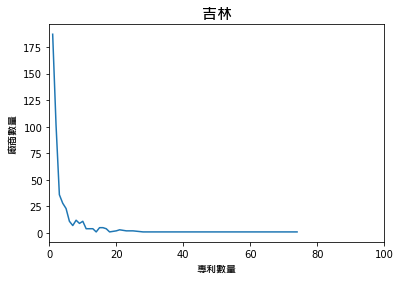

In [5]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('吉林',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [6]:
cleaned.to_excel(r'E:\paper\名稱merge\吉林_結果.xlsx')

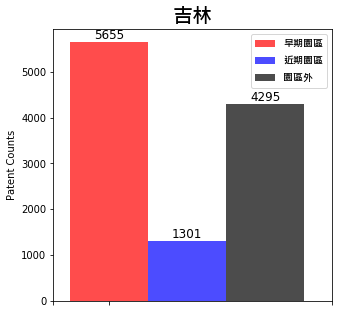

In [10]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('吉林',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)

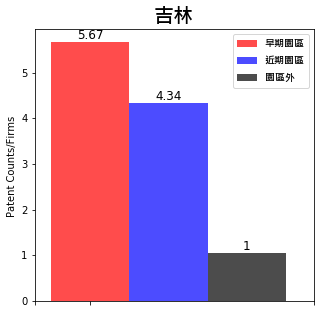

In [11]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('吉林',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)